In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import networkx as nx
import itertools
pd.options.display.max_columns=None

In [2]:
subdir = os.path.join(os.getcwd(), "scraped_processed")
zipdir = os.path.join(os.getcwd(), "folium_maps")

# Preprocessing

### Users

In [3]:
df_user = pd.read_csv(os.path.join(subdir, "users_final.csv"))
print(len(df_user))
df_user.head(5)

6145


,reviewer_name,reviewer_friends,reviewer_reviews,reviewer_photos,reviewer_origin,reviewer_ID,reviewer_elite_end,reviewer_elite_start
0,Vivian C.,139,1853,21209,"Boston, MA",nl8gWLDo6U6MjqzbBmE_9A,2020-01-01,2011-01-01
1,"Bruce ""Part of this complete breakfast"" K.",1799,14301,32966,"Charlotte, NC",hWDybu_KvYLSdEFzGrniTw,2020-01-01,2011-01-01
2,Kelly O.,147,964,112,"Boston, MA",1Y0zsJSfWLkfDylH0X1yNQ,2020-01-01,2011-01-01
3,"Michael ""The Wolf of Oak Street"" C.",956,1433,2036,"Boston, MA",ggl6fl-PM5O1WrdReL0l4A,2020-01-01,2011-01-01
4,Alexandra M.,608,1664,2047,"Boston, MA",5kMii2JySygayQpyPBjqCA,2020-01-01,2011-01-01


In [4]:
df_user["reviewer_ID"] = df_user["reviewer_ID"].astype("str")
df_user["reviewer_name"] = df_user["reviewer_name"].astype("str")
df_user["reviewer_origin"] = df_user["reviewer_origin"].astype("str")
df_user["reviewer_friends"] = df_user["reviewer_friends"].astype("int")
df_user["reviewer_reviews"] = df_user["reviewer_reviews"].astype("int")
df_user["reviewer_photos"] = df_user["reviewer_photos"].astype("int")
df_user["reviewer_elite_start"] = df_user["reviewer_elite_start"].astype("datetime64")
df_user["reviewer_elite_end"] = df_user["reviewer_elite_end"].astype("datetime64")

In [5]:
df_user.isna().sum()[df_user.isna().sum() > 0]

reviewer_elite_end      3325
reviewer_elite_start    3325
dtype: int64

In [6]:
df_user.head(5)

,reviewer_name,reviewer_friends,reviewer_reviews,reviewer_photos,reviewer_origin,reviewer_ID,reviewer_elite_end,reviewer_elite_start
0,Vivian C.,139,1853,21209,"Boston, MA",nl8gWLDo6U6MjqzbBmE_9A,2020-01-01,2011-01-01
1,"Bruce ""Part of this complete breakfast"" K.",1799,14301,32966,"Charlotte, NC",hWDybu_KvYLSdEFzGrniTw,2020-01-01,2011-01-01
2,Kelly O.,147,964,112,"Boston, MA",1Y0zsJSfWLkfDylH0X1yNQ,2020-01-01,2011-01-01
3,"Michael ""The Wolf of Oak Street"" C.",956,1433,2036,"Boston, MA",ggl6fl-PM5O1WrdReL0l4A,2020-01-01,2011-01-01
4,Alexandra M.,608,1664,2047,"Boston, MA",5kMii2JySygayQpyPBjqCA,2020-01-01,2011-01-01


### Restaurants

In [7]:
df_rest = pd.read_csv(os.path.join(subdir, "restaurants_final.csv"))
print(len(df_rest))
df_rest.head(5)

3425


,restaurant_name,restaurant_ID,restaurant_address,price,restaurant_neighborhood,restaurant_closed,ZIP_CODE,City,latitude,longitude
0,Grassona’s Italian,grassonas-italian-brookline,1704 Beacon St,2.0,Brookline,1,2445,Brookline,42.324397,-71.13933
1,Chiharu,chiharu-brookline,370 Boylston St,2.0,Brookline,0,2445,Brookline,42.324397,-71.13933
2,Knight Moves Cafe,knight-moves-cafe-brookline,1402 Beacon St,1.0,Brookline,0,2446,Brookline,42.344747,-71.12141
3,Fugakyu Japanese Cuisine,fugakyu-japanese-cuisine-brookline-2,1280 Beacon St,2.0,Brookline,0,2446,Brookline,42.344747,-71.12141
4,Brothers Restaurant,brothers-restaurant-brookline,404 Harvard St,2.0,Brookline,1,2446,Brookline,42.344747,-71.12141


In [8]:
df_rest["restaurant_ID"] = df_rest["restaurant_ID"].astype("str")
df_rest["restaurant_name"] = df_rest["restaurant_name"].astype("str")
df_rest["restaurant_neighborhood"] = df_rest["restaurant_neighborhood"].astype("str")
df_rest["restaurant_address"] = df_rest["restaurant_address"].astype("str")
df_rest["ZIP_CODE"] = df_rest["ZIP_CODE"].astype("str")
df_rest["City"] = df_rest["City"].astype("str")
df_rest["price"] = df_rest["price"].astype("float")
df_rest["latitude"] = df_rest["latitude"].astype("float")
df_rest["longitude"] = df_rest["longitude"].astype("float")

In [9]:
df_rest.isna().sum()[df_rest.isna().sum() > 0]

price        136
latitude      25
longitude     25
dtype: int64

In [10]:
df_rest.head(5)

,restaurant_name,restaurant_ID,restaurant_address,price,restaurant_neighborhood,restaurant_closed,ZIP_CODE,City,latitude,longitude
0,Grassona’s Italian,grassonas-italian-brookline,1704 Beacon St,2.0,Brookline,1,2445,Brookline,42.324397,-71.13933
1,Chiharu,chiharu-brookline,370 Boylston St,2.0,Brookline,0,2445,Brookline,42.324397,-71.13933
2,Knight Moves Cafe,knight-moves-cafe-brookline,1402 Beacon St,1.0,Brookline,0,2446,Brookline,42.344747,-71.12141
3,Fugakyu Japanese Cuisine,fugakyu-japanese-cuisine-brookline-2,1280 Beacon St,2.0,Brookline,0,2446,Brookline,42.344747,-71.12141
4,Brothers Restaurant,brothers-restaurant-brookline,404 Harvard St,2.0,Brookline,1,2446,Brookline,42.344747,-71.12141


### Reviews

In [11]:
df_reviews = pd.read_csv(os.path.join(subdir, "reviews_final.csv"), low_memory=False)
print(len(df_reviews))
df_reviews.head(5)

223015


,reviewer_ID,restaurant_ID,useful_count,funny_count,cool_count,review_rating,review_date
0,nl8gWLDo6U6MjqzbBmE_9A,grassonas-italian-brookline,2.0,1.0,1.0,3,08-01-2020
1,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4,13-08-2018
2,nl8gWLDo6U6MjqzbBmE_9A,knight-moves-cafe-brookline,3.0,1.0,2.0,4,26-06-2018
3,nl8gWLDo6U6MjqzbBmE_9A,fugakyu-japanese-cuisine-brookline-2,3.0,NaN,3.0,3,24-06-2018
4,nl8gWLDo6U6MjqzbBmE_9A,brothers-restaurant-brookline,4.0,NaN,NaN,3,29-11-2017


In [12]:
df_reviews["reviewer_ID"] = df_reviews["reviewer_ID"].astype("str")
df_reviews["restaurant_ID"] = df_reviews["restaurant_ID"].astype("str")
df_reviews["useful_count"] = df_reviews["useful_count"].astype("float64")
df_reviews["funny_count"] = df_reviews["funny_count"].astype("float64")
df_reviews["cool_count"] = df_reviews["cool_count"].astype("float64")
df_reviews["review_rating"] = df_reviews["review_rating"].astype("float64")
df_reviews["review_date"] = pd.to_datetime(df_reviews["review_date"])

In [13]:
df_reviews.isna().sum()[df_reviews.isna().sum() > 0]

useful_count    107294
funny_count     169390
cool_count      152065
dtype: int64

In [14]:
df_reviews.head(5)

,reviewer_ID,restaurant_ID,useful_count,funny_count,cool_count,review_rating,review_date
0,nl8gWLDo6U6MjqzbBmE_9A,grassonas-italian-brookline,2.0,1.0,1.0,3.0,2020-08-01
1,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4.0,2018-08-13
2,nl8gWLDo6U6MjqzbBmE_9A,knight-moves-cafe-brookline,3.0,1.0,2.0,4.0,2018-06-26
3,nl8gWLDo6U6MjqzbBmE_9A,fugakyu-japanese-cuisine-brookline-2,3.0,NaN,3.0,3.0,2018-06-24
4,nl8gWLDo6U6MjqzbBmE_9A,brothers-restaurant-brookline,4.0,NaN,NaN,3.0,2017-11-29


# Optimize Memory

In [15]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()/1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type in ["int64", "float64"]:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [16]:
reduce_mem_usage(df_reviews.copy(deep=True)).info()

Memory usage of dataframe is 11.91 MB
Memory usage after optimization is: 6.81 MB
Decreased by 42.9%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223015 entries, 0 to 223014
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   reviewer_ID    223015 non-null  object        
 1   restaurant_ID  223015 non-null  object        
 2   useful_count   115721 non-null  float16       
 3   funny_count    53625 non-null   float16       
 4   cool_count     70950 non-null   float16       
 5   review_rating  223015 non-null  float16       
 6   review_date    223015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float16(4), object(2)
memory usage: 6.8+ MB


In [17]:
reduce_mem_usage(df_user.copy(deep=True)).info()

Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.30 MB
Decreased by 0.0%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewer_name         6145 non-null   object        
 1   reviewer_friends      6145 non-null   int32         
 2   reviewer_reviews      6145 non-null   int32         
 3   reviewer_photos       6145 non-null   int32         
 4   reviewer_origin       6145 non-null   object        
 5   reviewer_ID           6145 non-null   object        
 6   reviewer_elite_end    2820 non-null   datetime64[ns]
 7   reviewer_elite_start  2820 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int32(3), object(3)
memory usage: 312.2+ KB


In [18]:
reduce_mem_usage(df_rest.copy(deep=True)).info()

Memory usage of dataframe is 0.26 MB
Memory usage after optimization is: 0.18 MB
Decreased by 31.2%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_name          3425 non-null   object 
 1   restaurant_ID            3425 non-null   object 
 2   restaurant_address       3425 non-null   object 
 3   price                    3289 non-null   float16
 4   restaurant_neighborhood  3425 non-null   object 
 5   restaurant_closed        3425 non-null   int8   
 6   ZIP_CODE                 3425 non-null   object 
 7   City                     3425 non-null   object 
 8   latitude                 3400 non-null   float16
 9   longitude                3400 non-null   float16
dtypes: float16(3), int8(1), object(6)
memory usage: 184.1+ KB


# Outlier Detection

### Users

In [19]:
num_cols = df_user.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns.tolist()

In [20]:
lo = 0.005
hi = 0.95
unique_id = []
for col in num_cols:
    init_len = len(df_user)
    q_lo = df_user[col].quantile(lo)
    q_hi = df_user[col].quantile(hi)
    final_len = len(df_user[(df_user[col] >= q_lo) & (df_user[col] <= q_hi)])
    unique_id.append(df_user[(df_user[col] > q_hi)].index.tolist())
    unique_id.append(df_user[(df_user[col] < q_lo)].index.tolist())
    print("Column:", col)
    print("Min Valid Value:", round(q_lo, 3))
    print("Max Valid Value:", round(q_hi, 3))
    print("Outliers Detected:", init_len - final_len)
    print("##########################")
print("Total Outliers:", len(set([uid for id_list in unique_id for uid in id_list])))

Column: reviewer_friends
Min Valid Value: 0.0
Max Valid Value: 532.0
Outliers Detected: 307
##########################
Column: reviewer_reviews
Min Valid Value: 15.0
Max Valid Value: 680.6
Outliers Detected: 337
##########################
Column: reviewer_photos
Min Valid Value: 0.0
Max Valid Value: 909.4
Outliers Detected: 308
##########################
Total Outliers: 666


### Restaurants

In [21]:
num_cols = df_rest.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [22]:
lo = 0.005
hi = 0.995
unique_id = []
for col in num_cols:
    init_len = len(df_rest)
    q_lo = df_rest[col].quantile(lo)
    q_hi = df_rest[col].quantile(hi)
    final_len = len(df_rest[(df_rest[col] >= q_lo) & (df_rest[col] <= q_hi)])
    unique_id.append(df_rest[(df_rest[col] > q_hi)].index.tolist())
    unique_id.append(df_rest[(df_rest[col] < q_lo)].index.tolist())
    print("Column:", col)
    print("Min Valid Value:", round(q_lo, 3))
    print("Max Valid Value:", round(q_hi, 3))
    print("Outliers Detected:", init_len - final_len)
    print("##########################")
print("Total Outliers:", len(set([uid for id_list in unique_id for uid in id_list])))

Column: price
Min Valid Value: 1.0
Max Valid Value: 4.0
Outliers Detected: 136
##########################
Column: restaurant_closed
Min Valid Value: 0.0
Max Valid Value: 1.0
Outliers Detected: 0
##########################
Column: latitude
Min Valid Value: 42.287
Max Valid Value: 42.4
Outliers Detected: 44
##########################
Column: longitude
Min Valid Value: -71.153
Max Valid Value: -71.026
Outliers Detected: 46
##########################
Total Outliers: 29


# Tags Analysis

### Tag Relationship Visualization

In [23]:
df_tags = pd.read_csv(os.path.join(subdir, "tags_final.csv"))
df_tags = df_tags.merge(df_tags, on="restaurant_ID").drop("restaurant_ID", axis=1)
df_tags = df_tags[df_tags["tag_x"] != df_tags["tag_y"]]
df_tags["count"] = 1
df_tags = df_tags.groupby(["tag_x", "tag_y"])["count"].sum().reset_index()
print(df_tags["count"].max())
print(len(df_tags)/2)

125
1384.0


In [24]:
df_tags = df_tags[df_tags["count"] > 15]

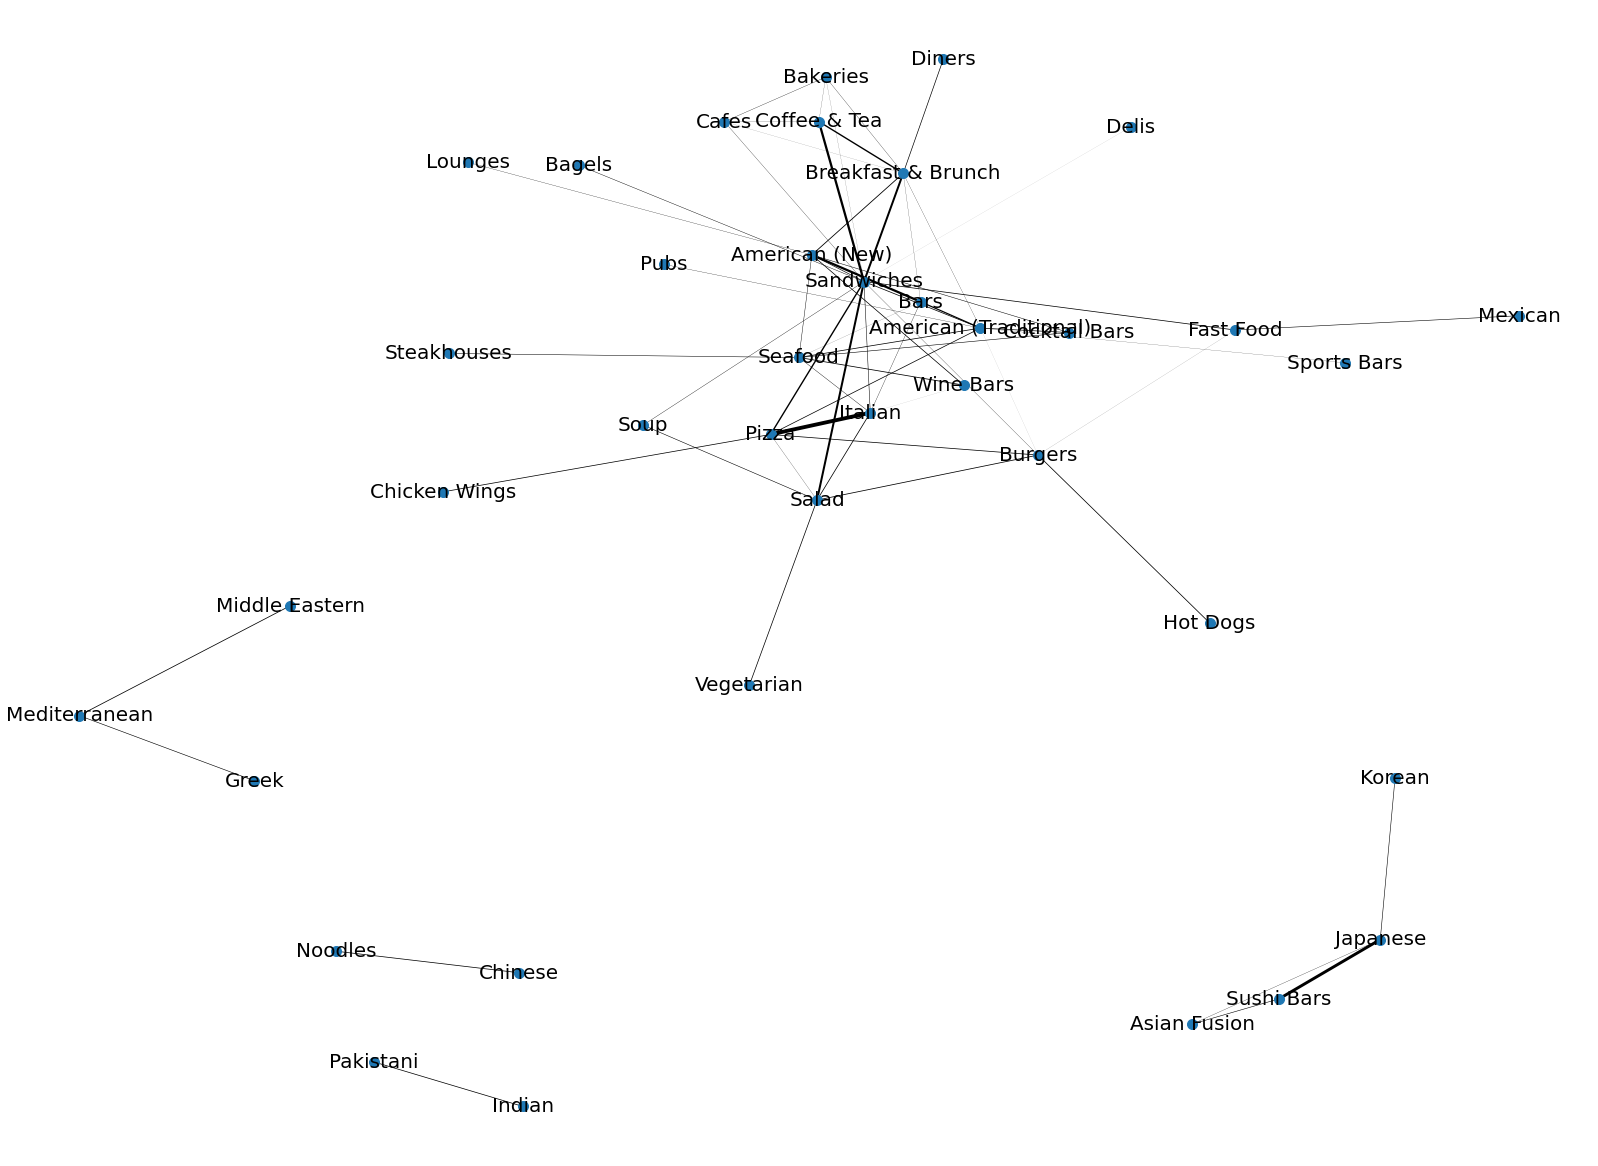

In [25]:
df_tags["count"] = (df_tags["count"] - df_tags["count"].mean())/df_tags["count"].std()

G = nx.from_pandas_edgelist(df_tags, "tag_x", "tag_y", "count")
edges = G.edges()
weights = [G[u][v]["count"] for u,v in edges]

plt.figure(3, figsize=(22, 16))
pos = nx.spring_layout(G, k=0.35, iterations=40)   
nx.draw(G, pos, node_size=100, labels={node:node for node in G.nodes()}, width=weights, font_size=20, font_family='sans-serif')

### Merge Tags

In [26]:
df_tags = pd.read_csv(os.path.join(subdir, "tags_final.csv"))
tag_counts = df_tags["tag"].value_counts().to_dict()

df_tags = df_tags.merge(df_tags, on="restaurant_ID").drop("restaurant_ID", axis=1)
df_tags = df_tags[df_tags["tag_x"] != df_tags["tag_y"]]
df_tags["count"] = 1
df_tags = df_tags.groupby(["tag_x", "tag_y"])["count"].sum().reset_index()

In [27]:
merge_list = []

for thres in range(1, 126):
    df = pd.read_csv(os.path.join(subdir, "tags_final.csv"))
    df = df.merge(df, on="restaurant_ID").drop("restaurant_ID", axis=1)
    df = df[df["tag_x"] != df["tag_y"]]
    df["count"] = 1
    df = df.groupby(["tag_x", "tag_y"])["count"].sum().reset_index()
    df = df[df["count"] >= thres]

    G = nx.from_pandas_edgelist(df, "tag_x", "tag_y", "count")
    edges = G.edges()
    weights = [G[u][v]["count"] for u,v in edges]
    
    for c in nx.connected_components(G):
        n_edges = len(G.subgraph(c).edges)
        n_nodes = len(G.subgraph(c).nodes)
        if n_edges == n_nodes*(n_nodes-1)/2:
            subgraph = list(G.subgraph(c).nodes)
            w = 2*df_tags[(df_tags["tag_x"] == subgraph[0]) & (df_tags["tag_y"] == subgraph[1])
                       ]["count"].values[0]/(tag_counts[subgraph[0]] + tag_counts[subgraph[1]])
            merge_list.append((list(G.subgraph(c).nodes), w*100))
            
merge_list.sort()
list(merge_list for merge_list, _ in itertools.groupby(merge_list))

[(['Bars', 'American (New)'], 27.076923076923077),
 (['Cantonese', 'Dim Sum'], 45.45454545454545),
 (['Chinese', 'Noodles'], 13.492063492063492),
 (['Coffee & Tea', 'Sandwiches'], 26.34730538922156),
 (['Indian', 'Pakistani'], 31.48148148148148),
 (['Italian', 'Pizza'], 34.3878954607978),
 (['Japanese', 'Sushi Bars'], 60.115606936416185),
 (['Mediterranean', 'Greek'], 29.850746268656714),
 (['Pizza', 'Italian'], 34.3878954607978),
 (['Southern', 'Barbeque'], 20.8955223880597),
 (['Spanish', 'Tapas Bars'], 45.0),
 (['Thai', 'Vietnamese'], 13.924050632911392)]

# ZIP CODE ANALYSIS

In [28]:
df_zip = pd.read_csv(os.path.join(subdir, "ma_zip_codes.csv"))
df_zip.head(5)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,2670,West Dennis,MA,41.659749,-70.17089,-5,1,"41.659749, -70.17089"
1,1301,Greenfield,MA,42.605524,-72.60098,-5,1,"42.605524, -72.60098"
2,1560,South Grafton,MA,42.177462,-71.69382,-5,1,"42.177462, -71.69382"
3,1730,Bedford,MA,42.496679,-71.27504,-5,1,"42.496679, -71.27504"
4,1983,Topsfield,MA,42.642471,-70.94424,-5,1,"42.642471, -70.94424"


In [29]:
df_agg = df_reviews.merge(df_rest, on="restaurant_ID", how="left")
df_agg = df_agg.groupby("ZIP_CODE").agg({'review_rating': ['count', 'mean'], 'restaurant_ID': 'nunique',
                                 'price': 'mean', 'reviewer_ID': 'nunique', }
                               ).reset_index()
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ["ZIP_CODE", "review_count", "average_rating", "restaurant_count", "average_price", "reviewer_count"]

df_agg.head(5)

,ZIP_CODE,review_count,average_rating,restaurant_count,average_price,reviewer_count
0,2010,45,3.666667,1,1.000000,45
1,2108,8789,3.737058,129,2.069946,3498
2,2109,6179,3.495226,130,1.885243,2731
3,2110,5410,3.475231,134,1.900335,2423
4,2111,16897,3.634728,178,1.793075,4289


In [30]:
df_agg.describe()

,review_count,average_rating,restaurant_count,average_price,reviewer_count
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,4551.326531,3.617056,69.897959,1.801945,1521.040816
std,5998.006222,0.317136,71.710136,0.438597,1526.974950
min,6.000000,2.200000,1.000000,1.000000,6.000000
25%,60.000000,3.560711,3.000000,1.700000,59.000000
50%,2526.000000,3.666667,47.000000,1.878882,1238.000000
75%,7376.000000,3.741379,116.000000,2.000000,2731.000000
max,28427.000000,4.066667,290.000000,3.400000,5336.000000


### Merge Postal Code Info

In [31]:
df_zip["Zip"] = df_zip["Zip"].astype("str")
df_agg = df_agg.merge(df_zip[["Zip", "Latitude", "Longitude", "City"]], left_on="ZIP_CODE", right_on="Zip", how="left")
df_agg.drop_duplicates(inplace=True)

df_agg["ZIP_CODE"] = df_agg["ZIP_CODE"].apply(lambda x: "0" + str(x))
df_agg["reviewer_count"] = df_agg["reviewer_count"]
df_agg.dropna(inplace=True)
df_agg = df_agg.reset_index(drop=True)

print(len(df_agg))
df_agg.head(5)

47


,ZIP_CODE,review_count,average_rating,restaurant_count,average_price,reviewer_count,Zip,Latitude,Longitude,City
0,02108,8789,3.737058,129,2.069946,3498,2108,42.357903,-71.064080,Boston
1,02109,6179,3.495226,130,1.885243,2731,2109,42.361477,-71.054170,Boston
2,02110,5410,3.475231,134,1.900335,2423,2110,42.356532,-71.053650,Boston
3,02111,16897,3.634728,178,1.793075,4289,2111,42.349838,-71.061010,Boston
4,02112,14,3.714286,1,1.000000,14,2112,42.338947,-70.919635,Boston


In [32]:
df_tags = pd.read_csv(os.path.join(subdir, "tags_final.csv"))

df_tags = df_rest[["restaurant_ID", "ZIP_CODE"]].merge(df_tags, on="restaurant_ID", how="inner")
df_tags = df_tags.groupby(["ZIP_CODE", "tag"]).count().reset_index()
df_tags = df_tags.set_index("tag").groupby("ZIP_CODE")["restaurant_ID"].nlargest(3).reset_index()
df_tags = df_tags.groupby('ZIP_CODE')['tag'].apply(list).reset_index()
df_tags.head(3)

,ZIP_CODE,tag
0,2010,"[Asian Fusion, Food Trucks]"
1,2108,"[Sandwiches, American (Traditional), American ..."
2,2109,"[Seafood, American (Traditional), Sandwiches]"


In [33]:
df_tags["ZIP_CODE"] = df_tags["ZIP_CODE"].apply(lambda x: "0" + str(x))
df_agg = df_agg.merge(df_tags, on="ZIP_CODE", how="left")

In [34]:
expected_reviews = (df_reviews.merge(df_rest, on="restaurant_ID", how="inner").groupby("restaurant_ID")["reviewer_ID"].count().mean())
expected_reviews

65.11386861313869

In [35]:
df_agg["expected_reviews"] = df_agg["restaurant_count"]*expected_reviews
df_agg["review_difference"] = (df_agg["review_count"] - df_agg["expected_reviews"])/df_agg["expected_reviews"]*100

In [36]:
df_agg

,ZIP_CODE,review_count,average_rating,restaurant_count,average_price,reviewer_count,Zip,Latitude,Longitude,City,tag,expected_reviews,review_difference
0,02108,8789,3.737058,129,2.069946,3498,2108,42.357903,-71.064080,Boston,"[Sandwiches, American (Traditional), American ...",8399.689051,4.634826
1,02109,6179,3.495226,130,1.885243,2731,2109,42.361477,-71.054170,Boston,"[Seafood, American (Traditional), Sandwiches]",8464.802920,-27.003617
2,02110,5410,3.475231,134,1.900335,2423,2110,42.356532,-71.053650,Boston,"[Sandwiches, American (New), Breakfast & Brunch]",8725.258394,-37.996106
3,02111,16897,3.634728,178,1.793075,4289,2111,42.349838,-71.061010,Boston,"[Chinese, Sandwiches, Japanese]",11590.268613,45.786095
4,02112,14,3.714286,1,1.000000,14,2112,42.338947,-70.919635,Boston,"[Food Trucks, Indian]",65.113869,-78.499204
5,02113,9639,3.897085,113,2.151147,3676,2113,42.365028,-71.056360,Boston,"[Italian, Wine Bars, Pizza]",7357.867153,31.002637
6,02114,5846,3.558844,96,2.005405,2626,2114,42.361792,-71.067740,Boston,"[Sandwiches, Italian, Pizza]",6250.931387,-6.477937
7,02115,10130,3.560711,157,1.881696,3623,2115,42.343080,-71.092680,Boston,"[Sandwiches, American (New), American (Traditi...",10222.877372,-0.908525
8,02116,28427,3.643825,290,2.257307,5336,2116,42.349622,-71.073720,Boston,"[American (New), Sandwiches, Bars]",18883.021898,50.542642
9,02117,6,3.666667,1,1.000000,6,2117,42.338947,-70.919635,Boston,[American (New)],65.113869,-90.785373


In [37]:
lat = df_agg["Latitude"].min() + (df_agg["Latitude"].max() - df_agg["Latitude"].min())/2

In [38]:
lng = df_agg["Longitude"].min() + (df_agg["Longitude"].max() - df_agg["Longitude"].min())/2

## Generate maps

# Review Date Analysis

In [39]:
df_reviews["review_date"].describe()

<ipython-input-39-7ff8bf346a31>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_reviews["review_date"].describe()


count                  223015
unique                   5564
top       2005-08-24 00:00:00
freq                      124
first     2005-01-07 00:00:00
last      2020-12-11 00:00:00
Name: review_date, dtype: object

In [40]:
df_reviews["review_days"] = (df_reviews["review_date"] - df_reviews["review_date"].min()).dt.days

In [41]:
df_date = df_reviews.groupby("reviewer_ID")["review_days"].apply(list).reset_index()
df_date["review_days"] = df_date["review_days"].apply(lambda x: sorted(x))
df_date["review_count"] = df_date["review_days"].apply(lambda x: len(x))
df_date["review_days_diff"] = df_date["review_days"].apply(lambda x: [element - x[i - 1] for i, element in enumerate(x)][1:])
df_date.isna().sum()

reviewer_ID         0
review_days         0
review_count        0
review_days_diff    0
dtype: int64

In [42]:
round(df_date["review_days_diff"].apply(lambda x: sum(x)/len(x))).describe()

count    6067.000000
mean       73.365584
std        69.010468
min         0.000000
25%        26.000000
50%        52.000000
75%        99.000000
max       697.000000
Name: review_days_diff, dtype: float64

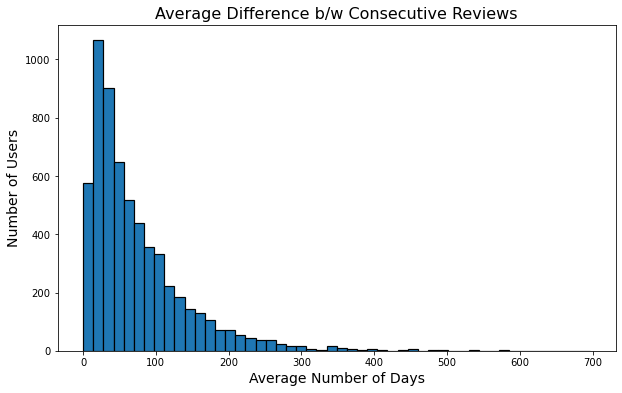

In [43]:
rcParams['figure.figsize'] = 10, 6
plt.hist(round(df_date["review_days_diff"].apply(lambda x: sum(x)/len(x))),
         edgecolor='black', linewidth=1.2, bins=50)
plt.xlabel("Average Number of Days", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.title("Average Difference b/w Consecutive Reviews", fontsize=16)
plt.show()

In [44]:
df_reviews["review_month"] = df_reviews["review_date"].dt.month_name()
df_reviews["review_weekday"] = df_reviews["review_date"].dt.day_name()

In [45]:
df_reviews["review_month"].unique()

array(['August', 'June', 'November', 'May', 'April', 'July', 'February',
       'December', 'October', 'March', 'January', 'September'],
      dtype=object)

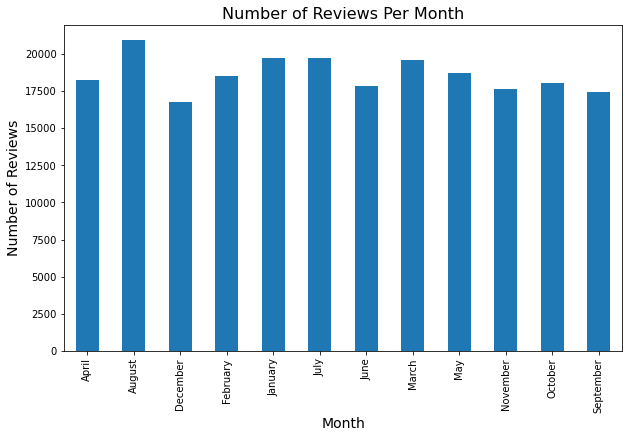

In [46]:
cats = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
        'September', 'October', 'November', 'December']
df_reviews["review_month"] = df_reviews["review_month"].astype('category')

ax = df_reviews["review_month"].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Reviews", fontsize=14)
plt.title("Number of Reviews Per Month", fontsize=16)
plt.show()

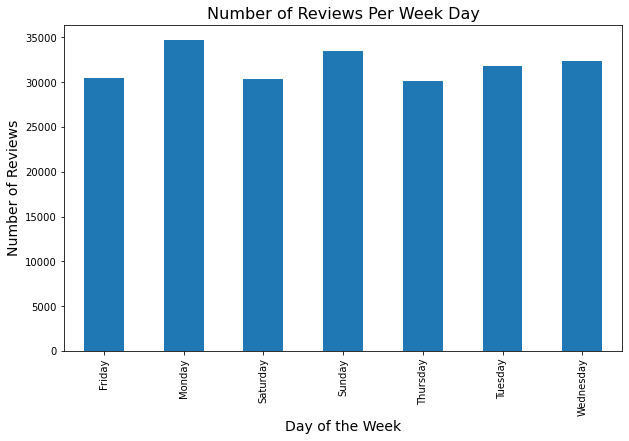

In [47]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_reviews["review_weekday"] = df_reviews["review_weekday"].astype('category')

ax = df_reviews["review_weekday"].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Day of the Week", fontsize=14)
ax.set_ylabel("Number of Reviews", fontsize=14)
plt.title("Number of Reviews Per Week Day", fontsize=16)
plt.show()

# Miscellaneous

In [48]:
df_tags = pd.read_csv(os.path.join(subdir, "tags_final.csv"))
df = df_reviews.merge(df_tags, on="restaurant_ID", how="left")
df.head(5)

,reviewer_ID,restaurant_ID,useful_count,funny_count,cool_count,review_rating,review_date,review_days,review_month,review_weekday,tag
0,nl8gWLDo6U6MjqzbBmE_9A,grassonas-italian-brookline,2.0,1.0,1.0,3.0,2020-08-01,5685,August,Saturday,Italian
1,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4.0,2018-08-13,4966,August,Monday,Sushi Bars
2,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4.0,2018-08-13,4966,August,Monday,Ramen
3,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4.0,2018-08-13,4966,August,Monday,Noodles
4,nl8gWLDo6U6MjqzbBmE_9A,knight-moves-cafe-brookline,3.0,1.0,2.0,4.0,2018-06-26,4918,June,Tuesday,Cafes


In [49]:
df.dropna(subset=["tag"], inplace=True)

In [50]:
df.groupby("reviewer_ID").agg({"tag": "nunique"}).reset_index()["tag"].describe()

count    6067.000000
mean       33.731828
std        16.279148
min         7.000000
25%        22.000000
50%        30.000000
75%        42.000000
max       175.000000
Name: tag, dtype: float64

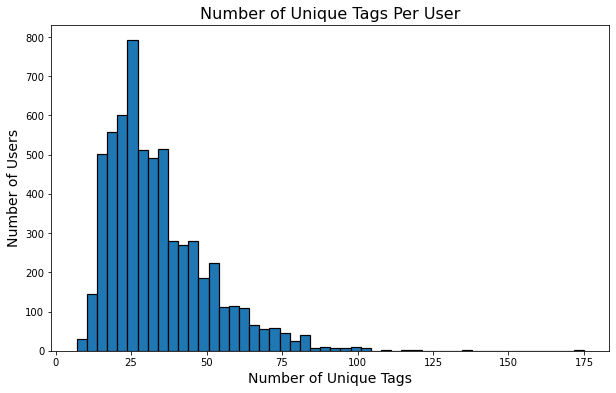

In [51]:
rcParams['figure.figsize'] = 10, 6
plt.hist(df.groupby("reviewer_ID").agg({"tag": "nunique"}).reset_index()["tag"],
         edgecolor='black', linewidth=1.2, bins=50)
plt.xlabel("Number of Unique Tags", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.title("Number of Unique Tags Per User", fontsize=16)
plt.show()

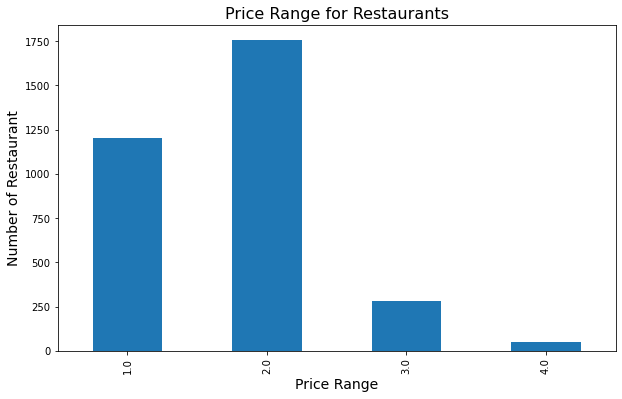

In [52]:
ax = df_rest["price"].astype("float").value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Price Range", fontsize=14)
ax.set_ylabel("Number of Restaurant", fontsize=14)
plt.title("Price Range for Restaurants", fontsize=16)
plt.show()

# Restuarant Geolocation Analysis

In [53]:
df_coords = pd.read_csv(os.path.join(subdir, "restaurants_location.csv"))
df_coords

,restaurant_ID,rest_lat,rest_long
0,stoli-bar-and-restaurant-brookline,42.331742,-71.115656
1,pon-thai-bistro-brookline,42.331742,-71.115656
2,the-fireplace-brookline,42.339521,-71.135886
3,shiki-brookline,42.343517,-71.122990
4,livite-brookline,42.339521,-71.135886
...,...,...,...
2983,c-f-donovans-dorchester,42.311697,-71.053394
2984,oasis-vegan-veggie-parlor-dorchester,42.308469,-71.083254
2985,my-sisters-crawfish-dorchester,42.301538,-71.059796
2986,windy-city-pizza-dorchester,42.279387,-71.067859


## Folium Heatmaps

In [54]:
rest_locations = df_coords[['rest_lat', 'rest_long']].values.tolist()
print(len(rest_locations))

2988


In [55]:
lat = df_coords['rest_lat'].min() + (df_coords['rest_lat'].max() - df_coords['rest_lat'].min())/2
lng = df_coords['rest_long'].min() + (df_coords['rest_long'].max() - df_coords['rest_long'].min())/2

In [56]:
df = df_reviews.merge(df_coords[['restaurant_ID', 'rest_lat', 'rest_long']], on="restaurant_ID", how="left")
df = df[df["rest_lat"].notna()]
print(len(df))
rest_counts = df.groupby(['rest_lat', 'rest_long'])["reviewer_ID"].count().reset_index().values.tolist()
print(len(rest_counts))

200009
1388


In [57]:
df["count"] = 1
df["review_year"] = df["review_date"].dt.year
year_list = []
for year in df.review_year.sort_values().unique():
    year_list.append(df.loc[df.review_year == year, ['rest_lat', 'rest_long', 'count']
                           ].groupby(['rest_lat', 'rest_long']).sum().reset_index().values.tolist())

In [58]:
df["review_month"] = df["review_date"].dt.year
month_list = []
for month in df.review_month.sort_values().unique():
    month_list.append(df.loc[df.review_month == month, ['rest_lat', 'rest_long', 'count']
                            ].groupby(['rest_lat', 'rest_long']).sum().reset_index().values.tolist())

## User Travel Patterns

In [59]:
df_travel = df_reviews.merge(df_coords, on="restaurant_ID", how="inner").groupby("reviewer_ID"
                                                                             )["restaurant_ID"].apply(list).reset_index()
geodict = df_coords.set_index("restaurant_ID").T.to_dict("list")

In [60]:
df_travel["rest_count"] = df_travel["restaurant_ID"].apply(lambda x: len(x))
df_travel["geocoords"] = df_travel["restaurant_ID"].apply(lambda x: [geodict[rest] for rest in x])
df_travel["geocoords"] = df_travel["geocoords"].apply(lambda x: [[radians(coords[0]), radians(coords[1])]  for coords in x])
df_travel["tot_dist"] = df_travel["geocoords"].apply(lambda x: np.triu((haversine_distances(x)), 1).sum()*6371000/1000)
df_travel["avg_dist"] = df_travel["tot_dist"]/(df_travel["rest_count"]*(df_travel["rest_count"]-1)/2)

In [61]:
df_travel["avg_dist"].describe()

count    6067.000000
mean        3.176687
std         0.888558
min         0.163155
25%         2.627556
50%         3.225008
75%         3.766959
max         8.277114
Name: avg_dist, dtype: float64

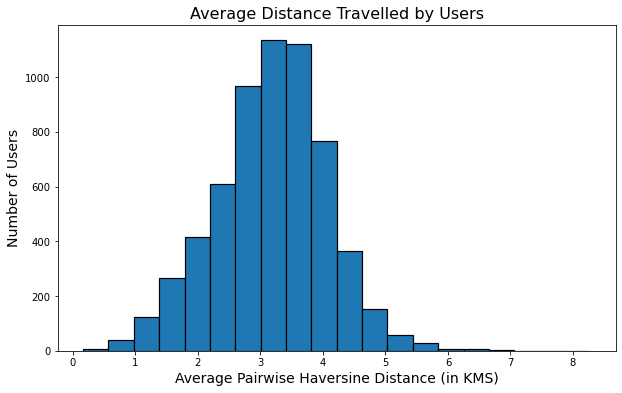

In [62]:
rcParams['figure.figsize'] = 10, 6
plt.hist(df_travel["avg_dist"], edgecolor='black', linewidth=1.2, bins=20)
plt.xlabel("Average Pairwise Haversine Distance (in KMS)", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.title("Average Distance Travelled by Users", fontsize=16)
plt.show()

## Ratings Analysis

In [63]:
min_yr = 2009
max_yr = 2018
df_reviews["review_year"] = df_reviews["review_date"].dt.year

In [64]:
df_year = df_reviews.groupby(["review_year"]).agg({"review_rating": ['mean', 'count']})
df_year.columns = df_year.columns.droplevel()
df_year = df_year.reset_index()
df_year = df_year[(df_year["review_year"] >= min_yr) & (df_year["review_year"] <= max_yr)]

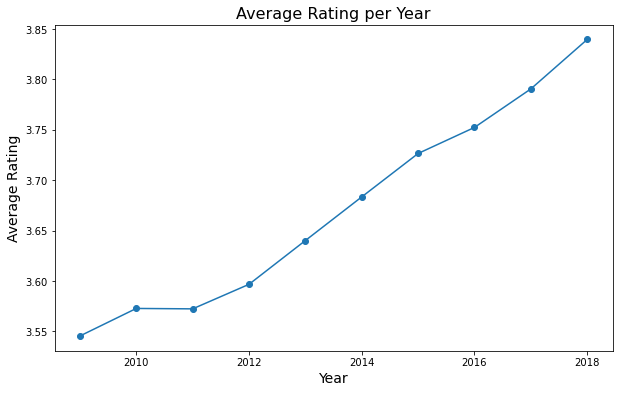

In [65]:
rcParams['figure.figsize'] = 10, 6
plt.scatter(df_year["review_year"], df_year["mean"])
plt.plot(df_year["review_year"], df_year["mean"])
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Rating", fontsize=14)
plt.title("Average Rating per Year", fontsize=16)
plt.show()

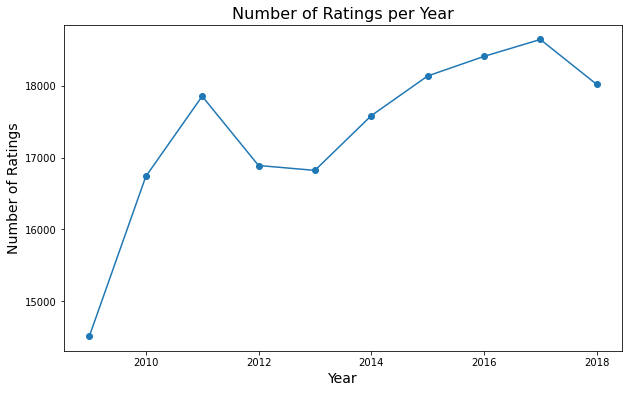

In [66]:
rcParams['figure.figsize'] = 10, 6
plt.scatter(df_year["review_year"], df_year["count"])
plt.plot(df_year["review_year"], df_year["count"])
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.title("Number of Ratings per Year", fontsize=16)
plt.show()

## User Votes Analysis

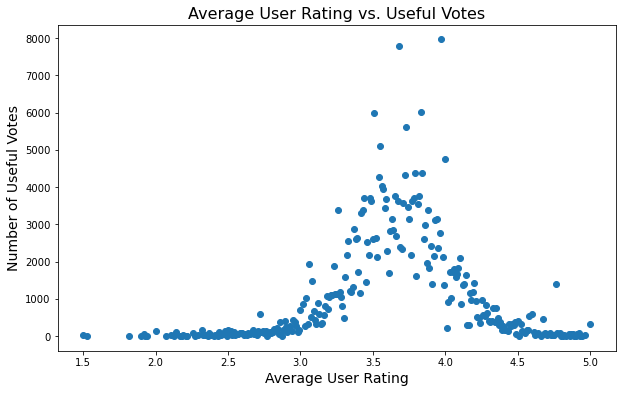

In [67]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "useful_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating")["useful_count"].sum().reset_index()

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["review_rating"], df_vote["useful_count"])
plt.xlabel("Average User Rating", fontsize=14)
plt.ylabel("Number of Useful Votes", fontsize=14)
plt.title("Average User Rating vs. Useful Votes", fontsize=16)
plt.show()

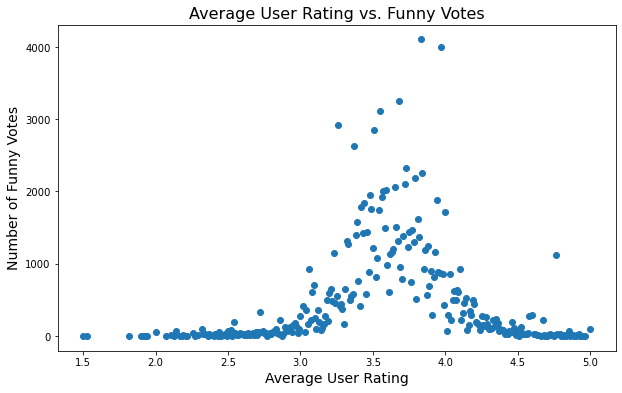

In [68]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "funny_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating")["funny_count"].sum().reset_index()

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["review_rating"], df_vote["funny_count"])
plt.xlabel("Average User Rating", fontsize=14)
plt.ylabel("Number of Funny Votes", fontsize=14)
plt.title("Average User Rating vs. Funny Votes", fontsize=16)
plt.show()

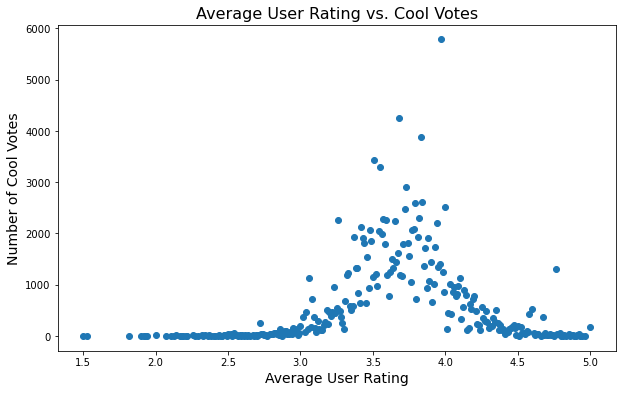

In [69]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "cool_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating")["cool_count"].sum().reset_index()

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["review_rating"], df_vote["cool_count"])
plt.xlabel("Average User Rating", fontsize=14)
plt.ylabel("Number of Cool Votes", fontsize=14)
plt.title("Average User Rating vs. Cool Votes", fontsize=16)
plt.show()

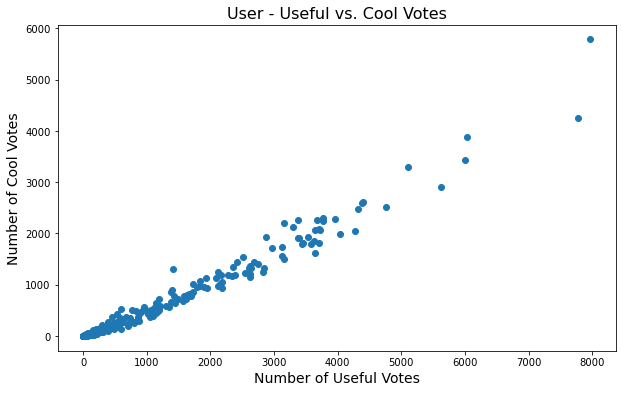

In [70]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "cool_count": "sum", "useful_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating").agg({"cool_count": "sum", "useful_count": "sum"})

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["useful_count"], df_vote["cool_count"])
plt.xlabel("Number of Useful Votes", fontsize=14)
plt.ylabel("Number of Cool Votes", fontsize=14)
plt.title("User - Useful vs. Cool Votes", fontsize=16)
plt.show()

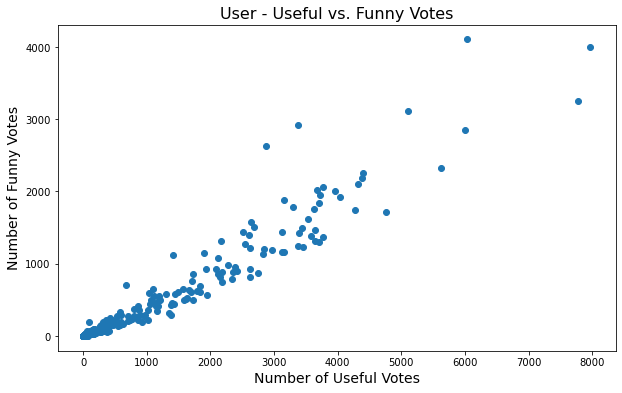

In [71]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "funny_count": "sum", "useful_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating").agg({"funny_count": "sum", "useful_count": "sum"})

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["useful_count"], df_vote["funny_count"])
plt.xlabel("Number of Useful Votes", fontsize=14)
plt.ylabel("Number of Funny Votes", fontsize=14)
plt.title("User - Useful vs. Funny Votes", fontsize=16)
plt.show()

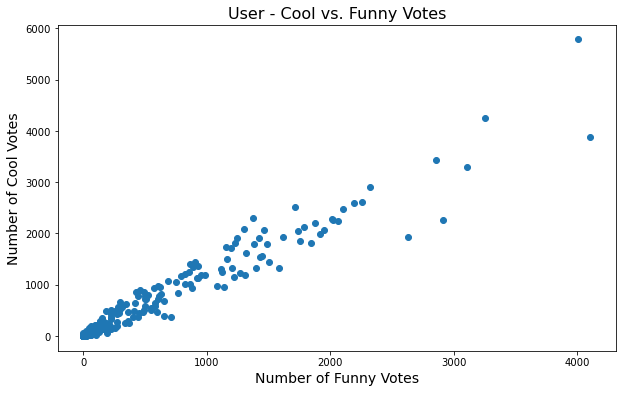

In [72]:
df_vote = df_reviews.groupby("reviewer_ID").agg({"review_rating": 'mean', "funny_count": "sum", "cool_count": "sum"}).reset_index()
df_vote["review_rating"] = df_vote["review_rating"].apply(lambda x: round(x, 2))
df_vote = df_vote.groupby("review_rating").agg({"funny_count": "sum", "cool_count": "sum"})

rcParams['figure.figsize'] = 10, 6
plt.scatter(df_vote["funny_count"], df_vote["cool_count"])
plt.xlabel("Number of Funny Votes", fontsize=14)
plt.ylabel("Number of Cool Votes", fontsize=14)
plt.title("User - Cool vs. Funny Votes", fontsize=16)
plt.show()